In [15]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np

import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from datasets import GeneralDataset
from Transforms import get_transformations
from utils import get_data_splits, get_input_params
from torchvision import utils
from train_mtl import mtl_experiment

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Choose parameters
- 4 channel full resolution:
```python
    task \in ['idh', '1p19q']
    dataformat \in ['raw3D', 'crop3Dslice', 'modality3D']
    modality \in ['all', 't1ce', 'flair', 't2', 't1', 't1ce-t1']
    include_genomic_data \in [True, False]
```

In [4]:
task = 'idh'
dataformat = 'crop3Dslice'
modality = 'all' # only relevent for 'modality3D' dataformat
include_genomic_data = False # don't include genomic data

dataformat, channels, resize_shape = get_input_params(dataformat)

In [5]:
print('task:\t\t', task)
print('dataformat:\t', dataformat)
print('channels:\t', channels)
print('modality:\t', modality)
print('resize_shape:\t', resize_shape)
print('include_genomic_data:\t', include_genomic_data)

task:		 idh
dataformat:	 cropped3D_mtl
channels:	 4
modality:	 all
resize_shape:	 (64, 64, 64)
include_genomic_data:	 False


In [17]:
# MRI directory
image_dir = '../data/all_brats_scans/'

# metadata for all brats (including tcia) data
## including: map from bratsIDs to tciaIDs; IDH & 1p/19q labels, and survival labels
best_model_loc = '../pretrained/espnet_3d_brats.pth' # segmentation model weights
glioma_metadata_df = pd.read_csv('../data/glioma_metadata.csv', index_col=0) # metadata file
glioma_metadata_df = glioma_metadata_df.drop(columns=['BoundingBox', 'some_seg', 'subtype'])

# get training splits
train_df, val_df, classes = get_data_splits(metadata_df=glioma_metadata_df, task=task, mtl=False)

# map between brats dataset and tcia data (tcia data is avalible for a subset of the brats patients)
brats2tcia_df = glioma_metadata_df['tciaID']

# these are labeled files (they were paths in old dataloader) but they are dataframes
labels_dict = {'train':train_df, 'val':val_df, 'data':glioma_metadata_df}

genomic_data_dict = {'train':'../data/MGL/MGL_235x50.csv', 'val':'../data/MGL/MGL_235x50.csv'}

label = task

print('Train size', len(train_df))

Train size 112


In [18]:
## get transformations
# MinMaxNormalize, Scale, "zero sprinle", "zero channel"
train_transformations, seg_transformations, val_transformations = get_transformations(channels=channels, 
                                                                                      resize_shape=resize_shape, 
                                                                                      prob_voxel_zero=0.2, 
                                                                                      prob_true=0.8, 
                                                                                      prob_channel_zero=0.5,
                                                                                      mtl=False)
data_transforms = {'train': train_transformations, 'val':   val_transformations}
                   
transformed_dataset_train = GeneralDataset(metadata_df=train_df, 
                                           root_dir=image_dir,
                                           genomic_csv_file = genomic_data_dict['train'],
                                           transform=train_transformations,
                                           seg_transform=seg_transformations,
                                           label=label,
                                           classes=classes,
                                           dataformat=dataformat,
                                           returndims=resize_shape,
                                           brats2tcia_df=brats2tcia_df,
                                           include_genomic_data = include_genomic_data,
                                           pretrained=best_model_loc,
                                           modality=modality)

transformed_dataset_val = GeneralDataset(metadata_df=val_df,
                                         root_dir=image_dir,
                                         genomic_csv_file = genomic_data_dict['val'],
                                         transform=val_transformations,
                                         seg_transform=seg_transformations,
                                         label=label,
                                         classes=classes,
                                         dataformat=dataformat,
                                         returndims=resize_shape,
                                         brats2tcia_df=brats2tcia_df,
                                         include_genomic_data = include_genomic_data,
                                         pretrained=best_model_loc,
                                         modality=modality)


# use Torch dataloader
image_datasets = {'train':transformed_dataset_train, 'val':transformed_dataset_val}

train_batch_size, val_batch_size = 4, 4
dataloader_train = DataLoader(image_datasets['train'], batch_size=train_batch_size, shuffle=True, num_workers=4)
dataloader_val = DataLoader(image_datasets['val'], batch_size=val_batch_size, shuffle=False, num_workers=4)

dataloaders = {'train':dataloader_train, 'val':dataloader_val}
dataset_sizes = {'train':len(image_datasets['train']), 'val':len(image_datasets['val'])}

class_names = image_datasets['train'].classes
class_names

['wildtype', 'mutant']

Brats18_TCIA10_632_1 image size: torch.Size([4, 4, 64, 64, 64])


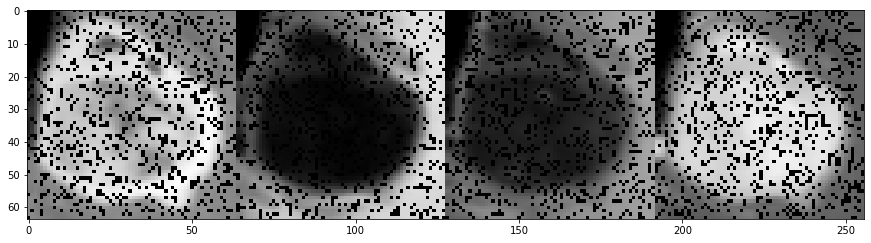

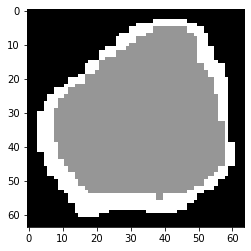

In [13]:
# visualize training (or validation) data
for i, data in enumerate(dataloaders['train']):
    # data batch
    (image, seg_image, genomic_data, seg_probs), label, (OS, OS_EVENT), bratsID = data
    # print scan ID
    print(bratsID[0], 'image size:', image.shape)
    
    # format MRI images (slices of volumetric input)
    img = image[0,:, :, :, int(image.shape[-1]/2)].squeeze()
    img = utils.make_grid(img)
    img = img.detach().cpu().numpy()
    
    # plot images
    plt.figure(figsize=(15, 8))
    img_list = [img[i].T for i in range(channels)] # 1 image per channel
    plt.imshow(np.hstack(img_list), cmap='Greys_r')
    plt.show()

    ## plot segmentation mask ##
    seg_img = seg_image[0, :, :, :, int(seg_image.shape[-1]/2)].squeeze()
    seg_img = utils.make_grid(seg_img).detach().cpu().numpy()

    plt.figure(figsize=(4, 4))
    plt.imshow(np.hstack([seg_img[0].T]), cmap='Greys_r')
    plt.show()

    break

In [14]:
?get_transformations

In [19]:
?GeneralDataset